# PyTorch Custom Datasets
### Resource Link : https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [1]:
import torch
from torch import nn
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import random
from PIL import Image
import numpy as np
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
os.cpu_count()

12

## Get custom data
A subset of https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/ <br>
3 classes of food with 75 train and 25 test images

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"Directory exists.")
else:
    image_path.mkdir(parents=True, exist_ok=True)
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)
    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

Directory exists.


## Data prep and exploration

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

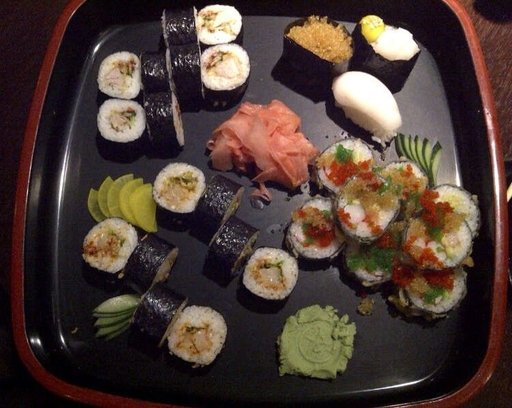

In [6]:
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg")) # test or train -> pizza or steak or sushi -> any image inside that

random_path = random.choice(image_path_list)

image_class = random_path.parent.stem

img = Image.open(random_path)

img

(-0.5, 511.5, 407.5, -0.5)

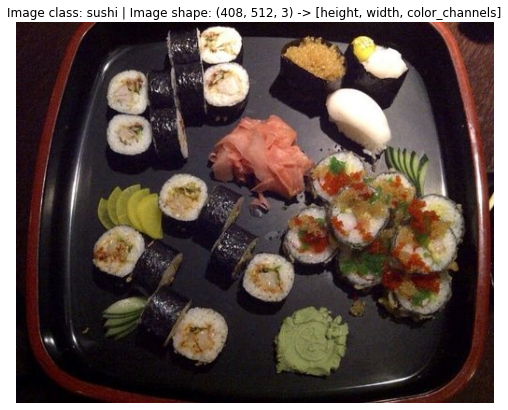

In [7]:
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## Transforming data
1. Turn your data into tensors
2. Turn it into torch dataset and subsequently into a torch dataloader

In [8]:
train_transform = transforms.Compose([transforms.Resize(size = (64,64)), #Resize the image
                                    transforms.RandomHorizontalFlip(p =0.5), #Flip the image with 50% probability
                                    transforms.ToTensor()]) #Turn the image to a tensor

test_transform = transforms.Compose([transforms.Resize(size = (64,64)), #Resize the image
                                    transforms.ToTensor()]) #Turn the image to a tensor

In [9]:
train_transform(img).shape

torch.Size([3, 64, 64])

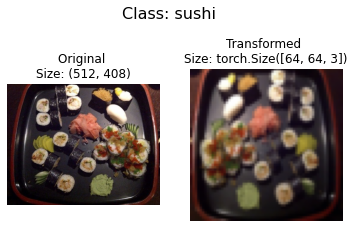

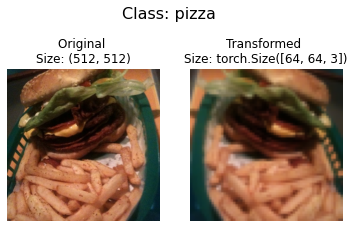

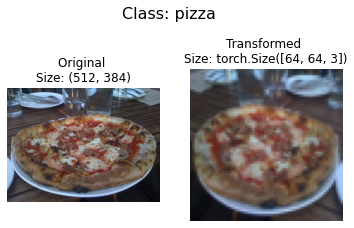

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_paths = random.sample(image_paths, k=n)
    for image_path in random_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=train_transform, n=3)

## Loading image data using `ImageFolder` and turning to a `DataLoader`

In [11]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


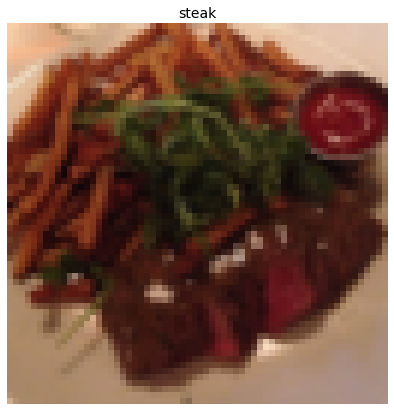

In [14]:
img, label = train_data[100][0], train_data[100][1]

img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [15]:
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = 1, # how many samples per batch?
                              num_workers = os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle = True) # shuffle the data?

test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = 1, 
                             num_workers = os.cpu_count(), 
                             shuffle = False) 

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ff20b82bb0>,
 <torch.utils.data.dataloader.DataLoader at 0x1ff20b82f70>)

## Function to display random images

In [16]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True):
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    # Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

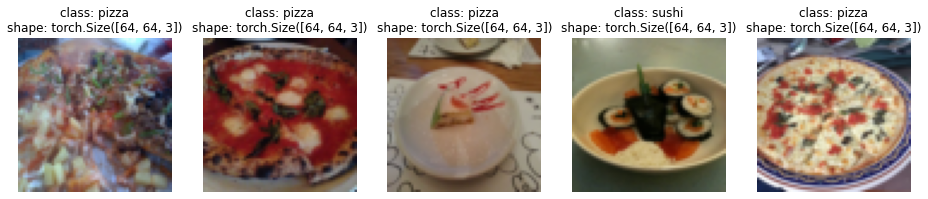

In [17]:
display_random_images(train_data, classes = class_names, n = 5)

## Augmentation transformation
### Trivial Augment
### https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [18]:
train_transform = transforms.Compose([transforms.Resize(size = (224, 224)), #Resize the image
                                      transforms.TrivialAugmentWide(num_magnitude_bins= 31), # Intensity of augmentation
                                      transforms.ToTensor()]) #Turn the image to a tensor

test_transform = transforms.Compose([transforms.Resize(size = (224, 224)), #Resize the image
                                     transforms.ToTensor()]) #Turn the image to a tensor

In [19]:
image_path_list[:5]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

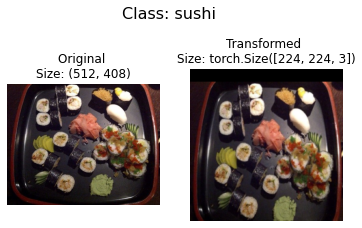

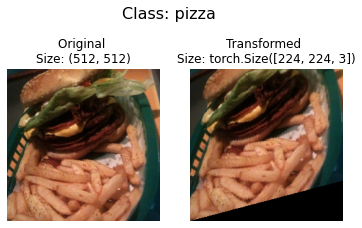

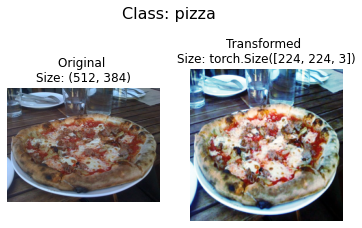

In [20]:
plot_transformed_images(image_path_list, transform = train_transform, n=3)

## Model 1 - Tiny VGG - No data augmentation

In [21]:
simple_transform = transforms.Compose([transforms.Resize(size = (64,64)),
                                       transforms.ToTensor()])

train_data_simple = datasets.ImageFolder(root = train_dir,
                                          transform = simple_transform,
                                          target_transform = None)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                         transform = simple_transform)

train_dataloader_simple = DataLoader(dataset = train_data_simple, 
                              batch_size = 32, 
                              num_workers = os.cpu_count(), 
                              shuffle = True) 

test_dataloader_simple = DataLoader(dataset = test_data_simple, 
                             batch_size = 32, 
                             num_workers = os.cpu_count(), 
                             shuffle = False) 

In [22]:
class Custom_VGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: 3):
        super().__init__()
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels = input_shape, out_channels = hidden_units,
                                                    kernel_size = 3, stride = 1, padding = 0),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                                                    kernel_size = 3, stride = 1, padding = 0),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size = 2))
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                                                    kernel_size = 3, stride = 1, padding = 0),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units,
                                                    kernel_size = 3, stride = 1, padding = 0),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size = 2))
        self.classifier_stack = nn.Sequential(nn.Flatten(),
                                              nn.Linear(in_features = hidden_units*13*13, out_features = output_shape))
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier_stack(x)
        return x

In [23]:
model_1 = Custom_VGG(input_shape = 3, hidden_units = 10, output_shape = len(class_names)).to(device)
model_1

Custom_VGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Dummy forward pass to fix classifier layer

In [24]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [25]:
model_1(image_batch.to(device))

tensor([[0.0293, 0.0581, 0.0162],
        [0.0265, 0.0581, 0.0179],
        [0.0242, 0.0580, 0.0176],
        [0.0286, 0.0566, 0.0178],
        [0.0254, 0.0597, 0.0179],
        [0.0284, 0.0544, 0.0149],
        [0.0265, 0.0550, 0.0161],
        [0.0284, 0.0562, 0.0177],
        [0.0281, 0.0559, 0.0159],
        [0.0333, 0.0571, 0.0144],
        [0.0270, 0.0601, 0.0170],
        [0.0288, 0.0615, 0.0194],
        [0.0298, 0.0578, 0.0156],
        [0.0323, 0.0632, 0.0133],
        [0.0327, 0.0617, 0.0130],
        [0.0273, 0.0570, 0.0112],
        [0.0300, 0.0522, 0.0151],
        [0.0268, 0.0557, 0.0169],
        [0.0274, 0.0597, 0.0126],
        [0.0236, 0.0582, 0.0143],
        [0.0225, 0.0607, 0.0143],
        [0.0256, 0.0557, 0.0177],
        [0.0265, 0.0615, 0.0168],
        [0.0266, 0.0563, 0.0145],
        [0.0308, 0.0531, 0.0131],
        [0.0353, 0.0563, 0.0145],
        [0.0315, 0.0540, 0.0117],
        [0.0275, 0.0570, 0.0169],
        [0.0257, 0.0567, 0.0132],
        [0.029

In [26]:
model_1(image_batch.to(device))

tensor([[0.0293, 0.0581, 0.0162],
        [0.0265, 0.0581, 0.0179],
        [0.0242, 0.0580, 0.0176],
        [0.0286, 0.0566, 0.0178],
        [0.0254, 0.0597, 0.0179],
        [0.0284, 0.0544, 0.0149],
        [0.0265, 0.0550, 0.0161],
        [0.0284, 0.0562, 0.0177],
        [0.0281, 0.0559, 0.0159],
        [0.0333, 0.0571, 0.0144],
        [0.0270, 0.0601, 0.0170],
        [0.0288, 0.0615, 0.0194],
        [0.0298, 0.0578, 0.0156],
        [0.0323, 0.0632, 0.0133],
        [0.0327, 0.0617, 0.0130],
        [0.0273, 0.0570, 0.0112],
        [0.0300, 0.0522, 0.0151],
        [0.0268, 0.0557, 0.0169],
        [0.0274, 0.0597, 0.0126],
        [0.0236, 0.0582, 0.0143],
        [0.0225, 0.0607, 0.0143],
        [0.0256, 0.0557, 0.0177],
        [0.0265, 0.0615, 0.0168],
        [0.0266, 0.0563, 0.0145],
        [0.0308, 0.0531, 0.0131],
        [0.0353, 0.0563, 0.0145],
        [0.0315, 0.0540, 0.0117],
        [0.0275, 0.0570, 0.0169],
        [0.0257, 0.0567, 0.0132],
        [0.029

### Using torchinfo to get shape details

In [27]:
import torchinfo
from torchinfo import summary
summary(model_1, input_size = [32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
Custom_VGG                               [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## Functionizing Training and Testing steps

In [28]:
from helper_functions import accuracy_fn

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

In [30]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.train()
    
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

In [32]:
def model_train(model: torch.nn.Module,
                train_data_loader: torch.utils.data.DataLoader,
                test_data_loader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                epochs: int = 5,
                device = device):
    
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_data_loader, loss_fn, optimizer, accuracy_fn, device)
        test_loss, test_acc = test_step(model, test_data_loader, loss_fn, accuracy_fn, device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

## Train and evaluate model

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1_res = model_train(model_1, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, 5, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1047 | train_acc: 25.3906 | test_loss: 1.0950 | test_acc: 42.1402
Epoch: 2 | train_loss: 1.0744 | train_acc: 45.3125 | test_loss: 1.1196 | test_acc: 26.0417
Epoch: 3 | train_loss: 1.0621 | train_acc: 42.5781 | test_loss: 1.1375 | test_acc: 26.0417
Epoch: 4 | train_loss: 1.0634 | train_acc: 33.5938 | test_loss: 1.0875 | test_acc: 29.1667
Epoch: 5 | train_loss: 1.0300 | train_acc: 45.3125 | test_loss: 1.0451 | test_acc: 43.4659


In [41]:
def plot_loss_curves(results: dict[str, list[float]]):
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    loss = [float(tensor) for tensor in loss]
    test_loss = results['test_loss']
    test_loss = [float(tensor) for tensor in test_loss]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
 
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

<class 'float'>
<class 'float'>


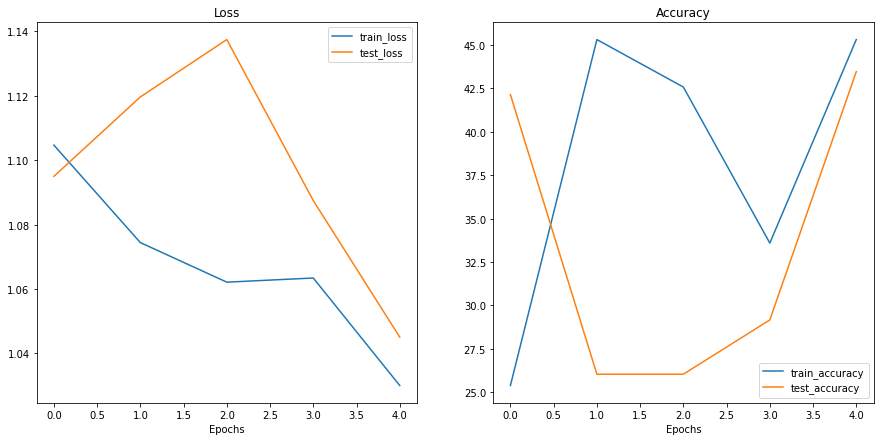

In [35]:
plot_loss_curves(model_1_res)

## Model 2 - Tiny VGG - With data augmentation

In [36]:
augment_transform = transforms.Compose([transforms.Resize(size = (64,64)),
                                        transforms.TrivialAugmentWide(num_magnitude_bins= 31),
                                       transforms.ToTensor()])

train_data_augment = datasets.ImageFolder(root = train_dir,
                                          transform = augment_transform,
                                          target_transform = None)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                         transform = simple_transform)

train_dataloader_augment = DataLoader(dataset = train_data_augment, 
                              batch_size = 32, 
                              num_workers = os.cpu_count(), 
                              shuffle = True) 

test_dataloader_simple = DataLoader(dataset = test_data_simple, 
                             batch_size = 32, 
                             num_workers = os.cpu_count(), 
                             shuffle = False) 

In [37]:
torch.manual_seed(42)
model_2 = Custom_VGG(input_shape = 3, hidden_units = 10, output_shape = len(class_names)).to(device)
model_2

Custom_VGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2_res = model_train(model_2, train_dataloader_augment, test_dataloader_simple, optimizer, loss_fn, 5, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1045 | train_acc: 25.0000 | test_loss: 1.1016 | test_acc: 26.0417
Epoch: 2 | train_loss: 1.0760 | train_acc: 42.5781 | test_loss: 1.1317 | test_acc: 26.0417
Epoch: 3 | train_loss: 1.0730 | train_acc: 42.5781 | test_loss: 1.1706 | test_acc: 26.0417
Epoch: 4 | train_loss: 1.1223 | train_acc: 30.4688 | test_loss: 1.1542 | test_acc: 26.0417
Epoch: 5 | train_loss: 1.0730 | train_acc: 47.2656 | test_loss: 1.1492 | test_acc: 29.1667


<class 'float'>
<class 'float'>


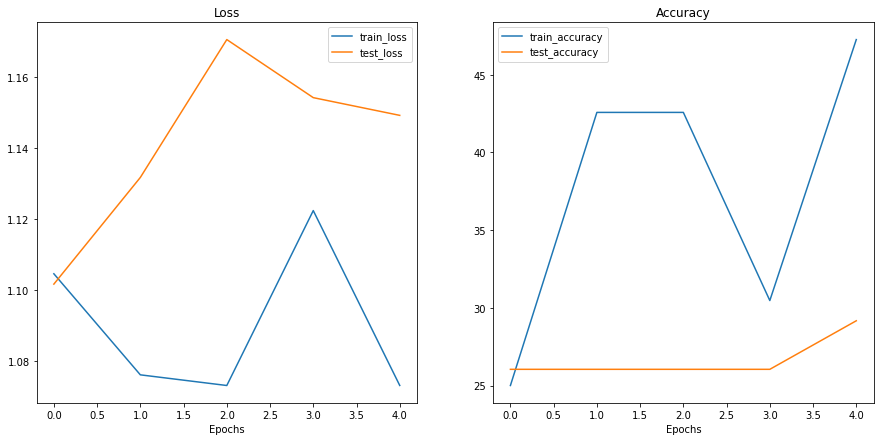

In [40]:
plot_loss_curves(model_2_res)

In [46]:
for key,val in model_1_res.items():
    model_1_res[key] = [float(tensor) for tensor in model_1_res[key]]
    
for key,val in model_2_res.items():
    model_2_res[key] = [float(tensor) for tensor in model_2_res[key]]

model_1_df = pd.DataFrame(model_1_res)
model_2_df = pd.DataFrame(model_2_res)

model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.104690,25.390625,1.094982,42.140152
1,1.074419,45.312500,1.119649,26.041667
2,1.062127,42.578125,1.137462,26.041667
3,1.063416,33.593750,1.087467,29.166667
4,1.030034,45.312500,1.045056,43.465909


In [47]:
model_2_df

,train_loss,train_acc,test_loss,test_acc
0,1.104503,25.000000,1.101592,26.041667
1,1.075997,42.578125,1.131682,26.041667
2,1.072989,42.578125,1.170574,26.041667
3,1.122329,30.468750,1.154193,26.041667
4,1.073001,47.265625,1.149195,29.166667


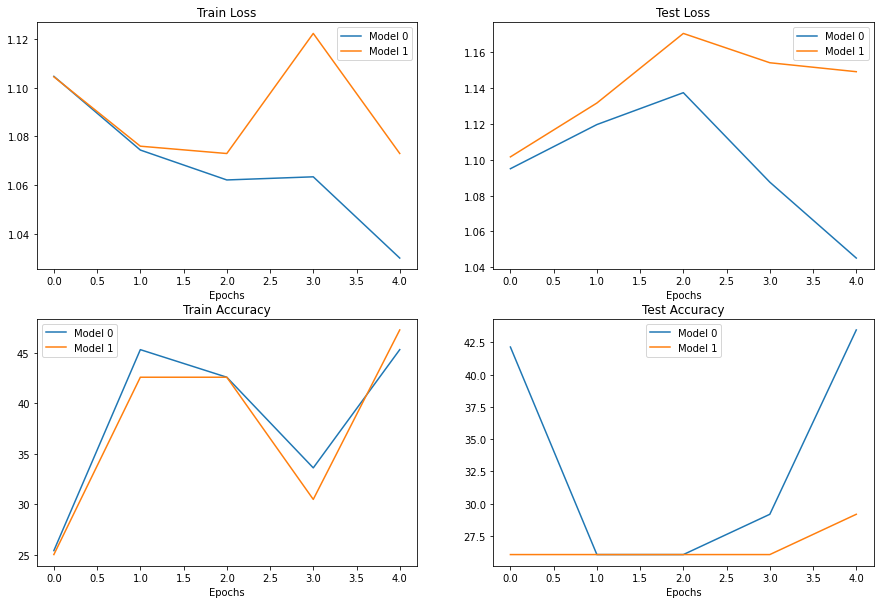

In [49]:
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_1_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_1_df["train_loss"], label="Model 0")
plt.plot(epochs, model_2_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_1_df["test_loss"], label="Model 0")
plt.plot(epochs, model_2_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_1_df["train_acc"], label="Model 0")
plt.plot(epochs, model_2_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_1_df["test_acc"], label="Model 0")
plt.plot(epochs, model_2_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Prediction on out of dataset image
1. Turn image to tensor
2. Convert to same datatype as that used while training model
3. Convert to same shape (3, 64, 64)
4. Make sure image on same device as model

In [51]:
import requests

custom_img_path = data_path / "04-pizza-dad.jpeg"

if not custom_img_path.is_file():
    with open(custom_img_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        f.write(request.content)
else:
    print("Image already present")

Image already present


In [55]:
cust_img = torchvision.io.read_image(str(custom_img_path)).type(torch.float32) / 255.

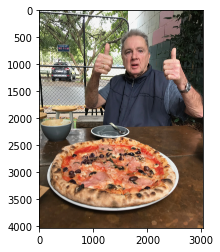

In [56]:
plt.imshow(cust_img.permute(1,2,0))

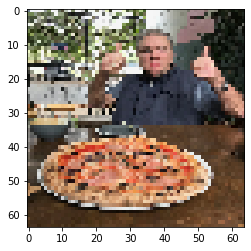

In [58]:
custom_transform = transforms.Compose([transforms.Resize(size = (64,64))])
cust_img_transformed = custom_transform(cust_img)
plt.imshow(cust_img_transformed.permute(1,2,0))

In [61]:
cust_img_transformed = cust_img_transformed.unsqueeze(dim = 0)

In [71]:
model_2.eval()

with torch.inference_mode():
    cust_img_pred = model_2(cust_img_transformed.to(device))
    cust_img_prob = torch.softmax(cust_img_pred, dim = 1)
    cust_img_label = class_names[torch.argmax(cust_img_prob, dim = 1)]
cust_img_label

'steak'

In [74]:
def pred_cust_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: list[str] = None, 
                        transform = None,
                        device: torch.device = device):
    target_img = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
    
    if transform:
        target_img = transform(target_img)
    
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_img = target_img.unsqueeze(dim=0)
        # Make a prediction on image with an extra dimension and send it to the target device
        target_img_pred = model(target_img.to(device))
        
    target_img_probs = torch.softmax(target_img_pred, dim=1)
    target_img_label = torch.argmax(target_img_probs, dim=1)
    plt.imshow(target_img.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    
    if class_names:
        title = f"Pred: {class_names[target_img_label.cpu()]} | Prob: {target_img_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_img_label} | Prob: {target_img_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

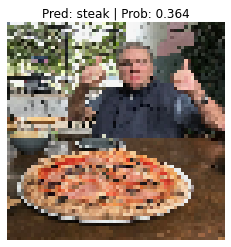

In [75]:
pred_cust_image(model=model_2,
                    image_path=custom_img_path,
                    class_names=class_names,
                    transform=custom_transform,
                    device=device)